In [1]:
# importing modules to use
import numpy as np

import pandas as pd

import os

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import signal
from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq
from scipy.stats import cauchy
from scipy.special import legendre
from scipy import interpolate
from IPython.display import display, clear_output



In [2]:
#Droplet Oscillation Fast Fourier Transform Analysis
import DOFFTA

In [8]:
filepath = input('File location: ').replace('"','')

#file location
dir_path = os.path.dirname(filepath)
print( dir_path)


File location: /Users/danhardy/Desktop/DOFFTA  test data/aspect ratio.txt
/Users/danhardy/Desktop/DOFFTA  test data


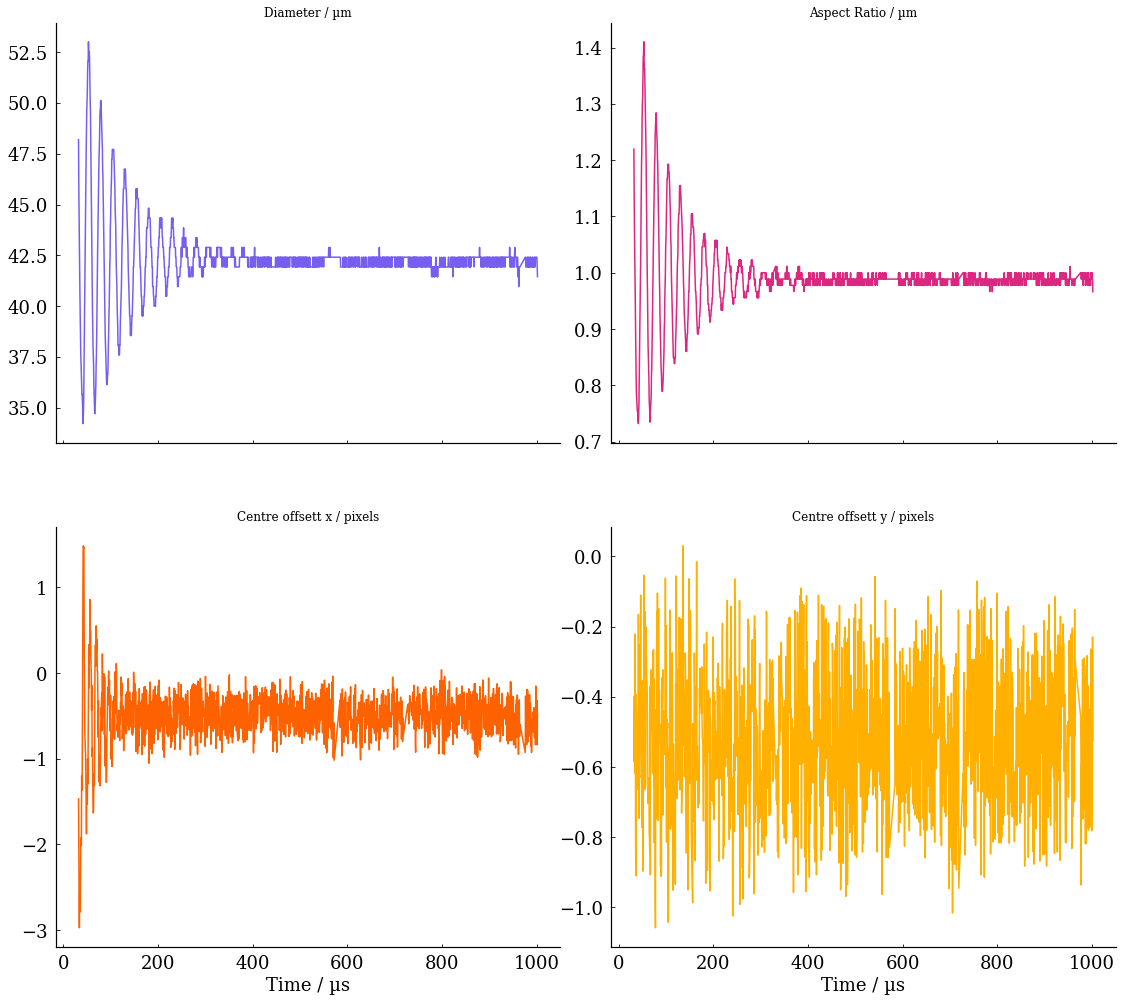

In [9]:
experimental_data = DOFFTA.import_data(filepath)
DOFFTA.review_data(experimental_data)

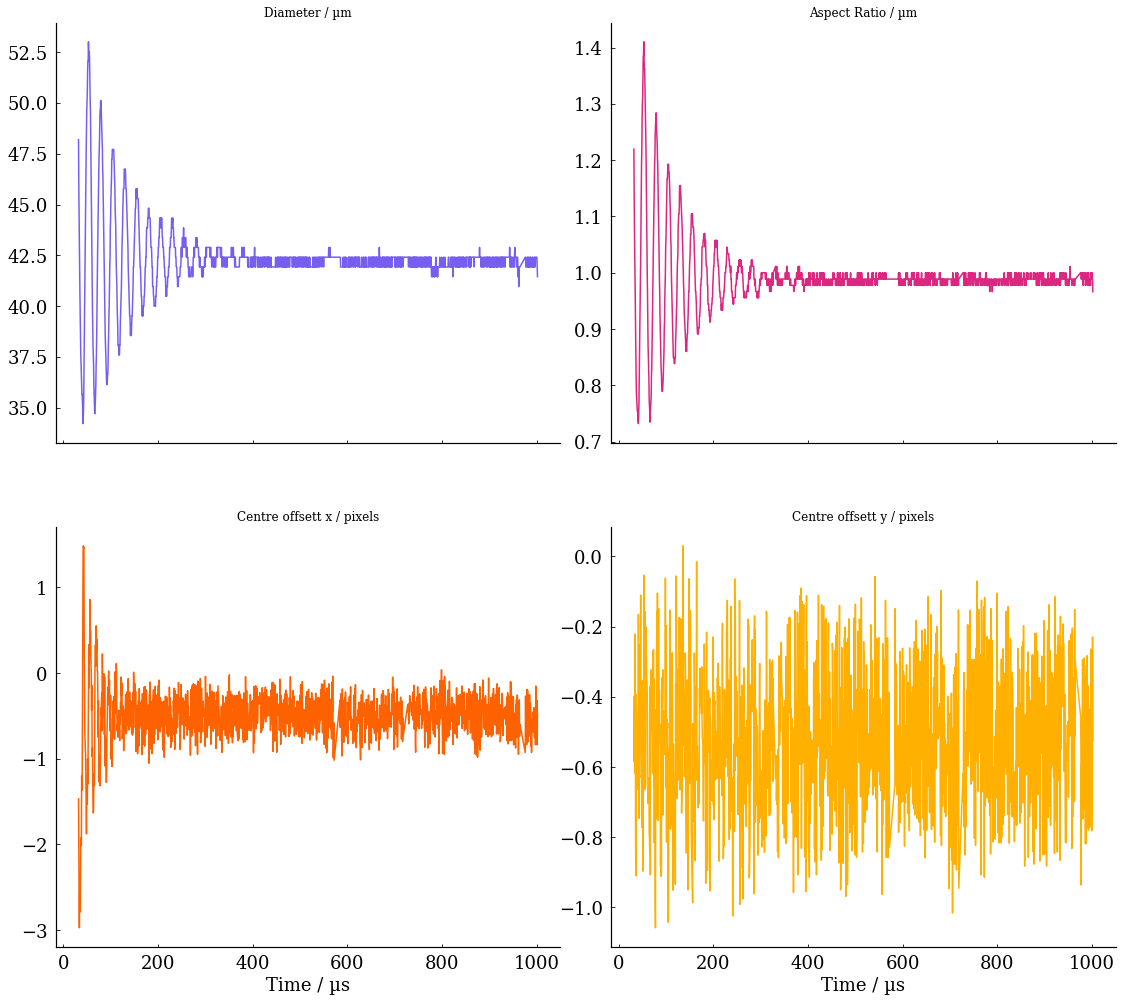

In [10]:
experimental_data = DOFFTA.remove_unecessary_data(experimental_data,)
DOFFTA.review_data(experimental_data)

In [11]:
d_final, d_final_std, AR_final, d_correction, d_calibrated, A_0_estimate = DOFFTA.get_calibrated_diameter(experimental_data)


In [12]:
calibrated_data = DOFFTA.get_calibrated_data(experimental_data, d_correction)

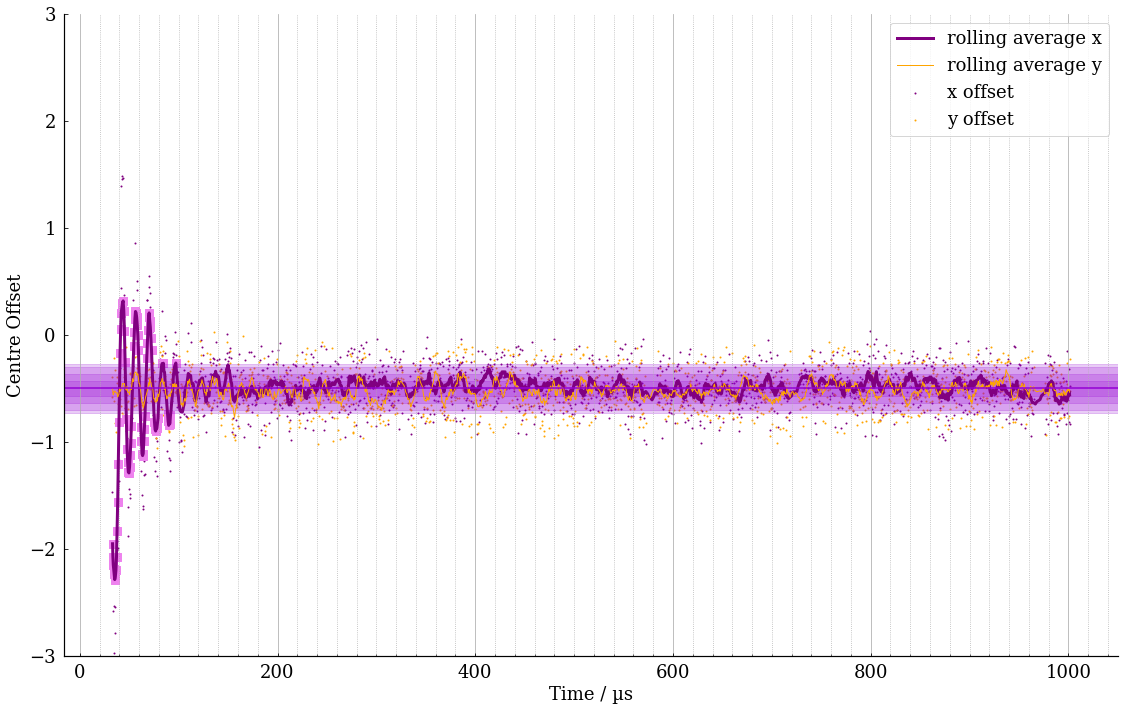

Calculated cut off (µs): 97.15
Is this cut off sensible? 

If yes, press enter. 

If no, enter a suggested value below (in µs):



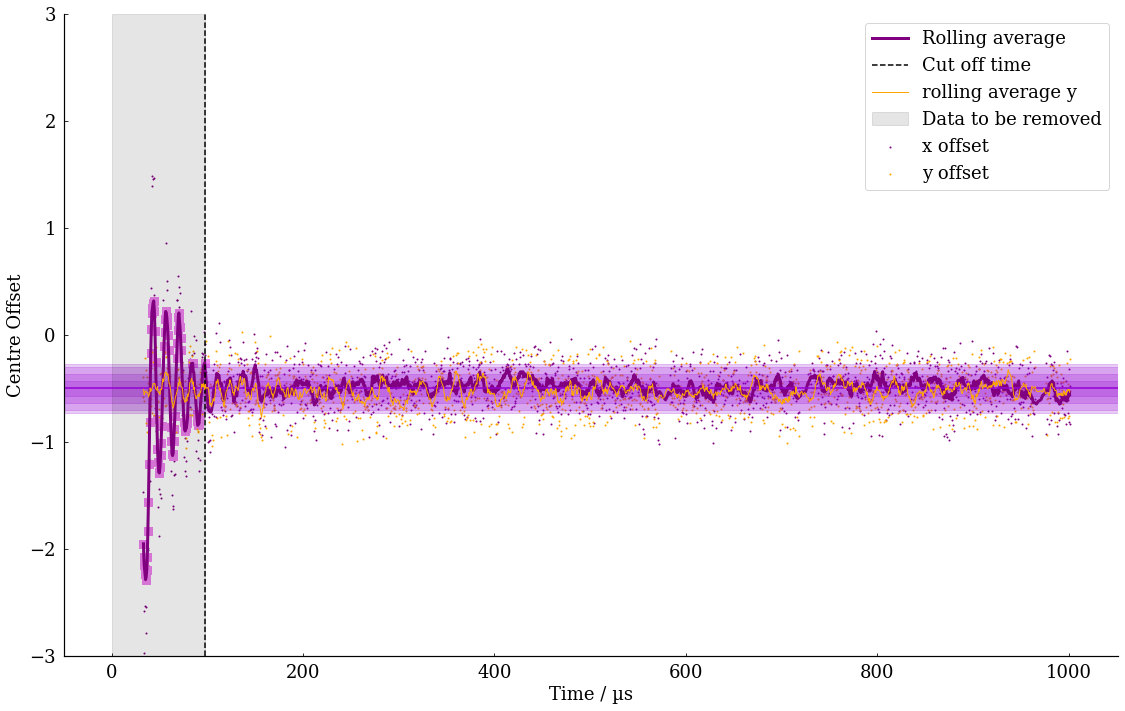

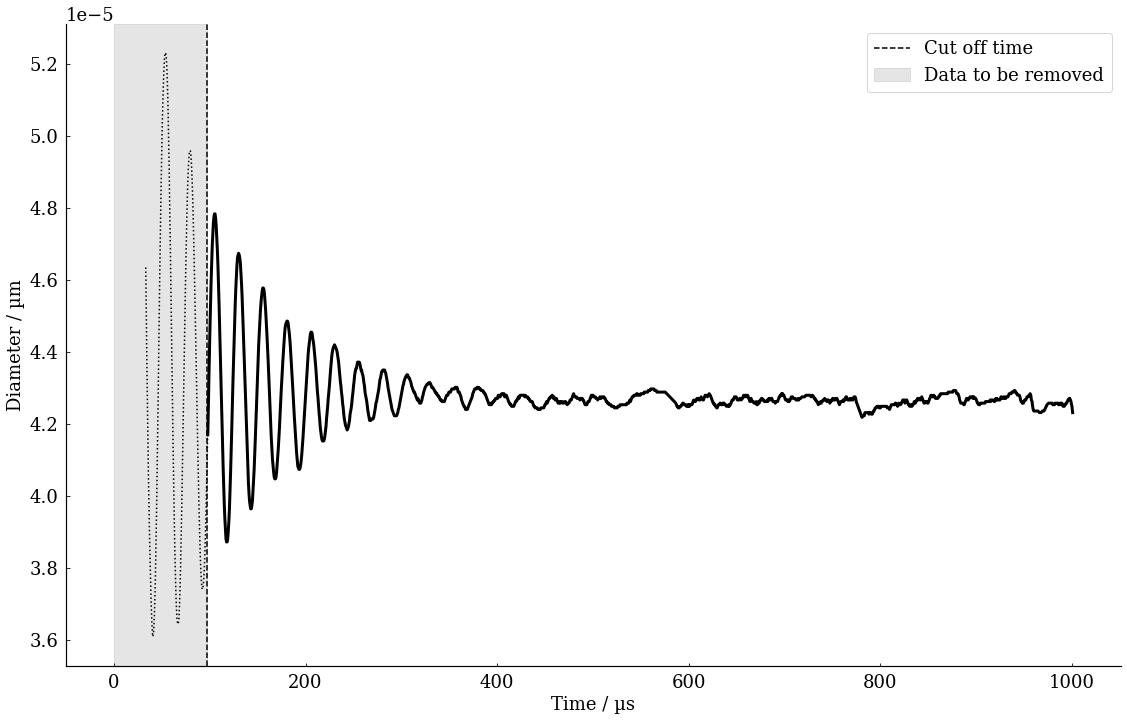

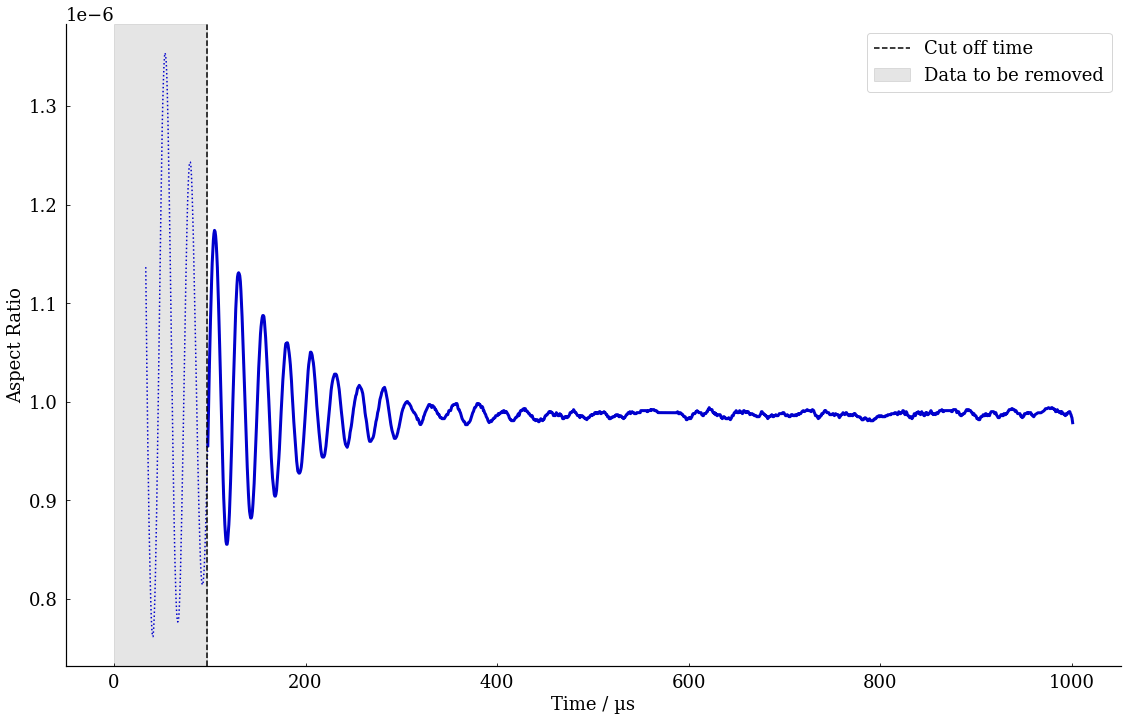

In [13]:
trimmed_data = DOFFTA.review_centre_offset(calibrated_data, save_figures='y', save_location= dir_path)

## Frequency cut offs
For the fft fits. These values are also used in the slied method below.

In [14]:
#change these if desired. Set to extremes if you would like no data to be cut (eg min = 0 and max = 10e9)
min_frequency = 10e3
max_frequency = 100e3

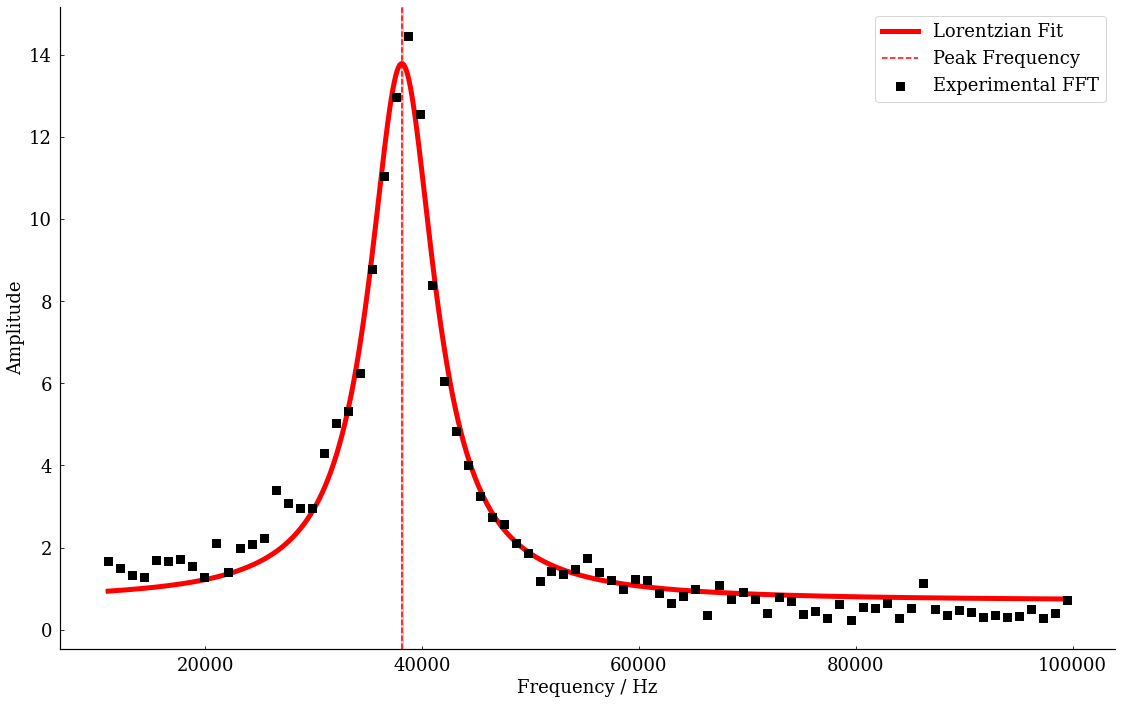

Surface tension / mN/m:
67.15 ± 1.776


In [15]:
sigma, sigma_error, lorentzian_fit_data, experimental_fft = DOFFTA.full_surface_tension_calculation(trimmed_data.time_s,
                                                                                                   trimmed_data.aspect_ratio.values,
                                                                                                   d_final/2,
                                                                                                   d_final_std/2,
                                                                                                   density = DOFFTA.rho_water,
                                                                                                   low_freq_cut_off=min_frequency,
                                                                                                   high_freq_cut_off=max_frequency)

print("Surface tension / mN/m:\n" + str(round(sigma*1e3,3)) + ' ± ' + str(round(sigma_error*1e3,3)))



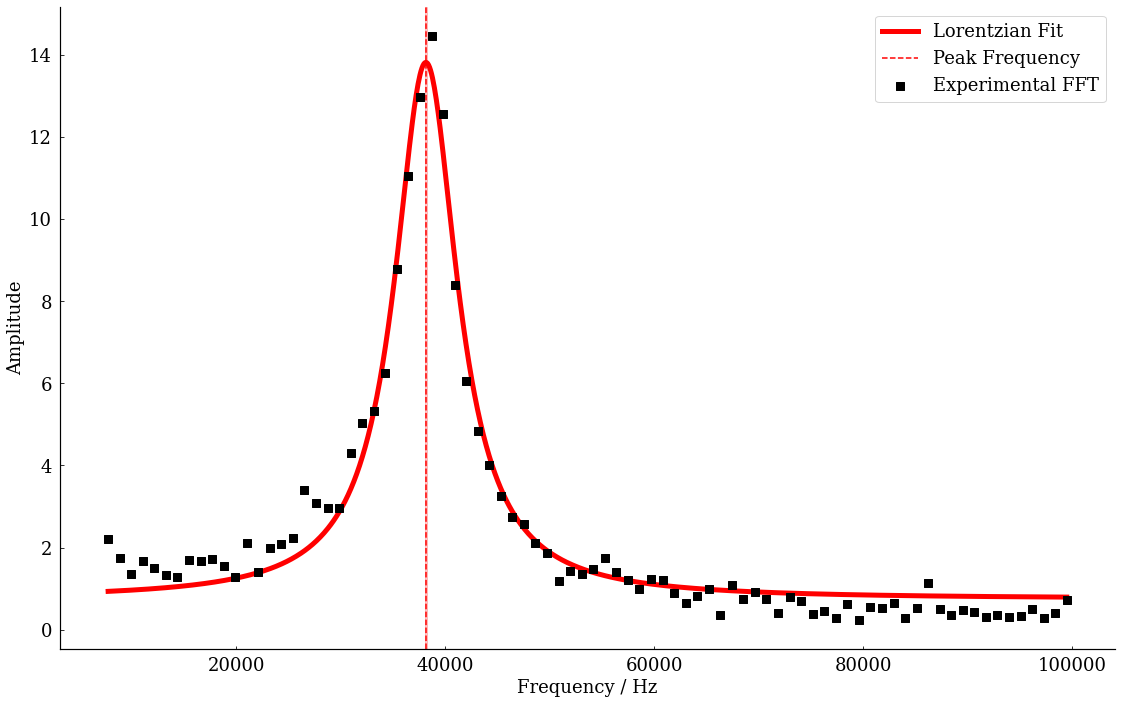

In [16]:


DOFFTA.save_experiment_parameters(dir_path,calibrated_data, trimmed_data)

In [17]:
print('Observed Diameter / µm: \t' + str(d_final/1e-6))
print('Observed Diameter Std Dev / µm: \t' + str(d_final_std/1e-6))
print('Blur Corrected Diameter / µm: \t' + str(d_calibrated/1e-6))
print('Expected Diameter / µm: \t' + str(2*DOFFTA.get_water_true_diameter(sigma,d_calibrated/2)/1e-6))

Observed Diameter / µm: 	42.16385579999996
Observed Diameter Std Dev / µm: 	0.3101021492770145
Blur Corrected Diameter / µm: 	42.639692036167695
Expected Diameter / µm: 	43.803629947052116


In [18]:
rho_water = 998
def chopped_surface_tension_calculations(data_list, slice_points, equilibrium_radius, mode_order = 2, density = rho_water, low_freq_cut_off = 0, high_freq_cut_off = 100e3, save_figures = 'n', save_location = 'NaN'):
    
    fft_list = []
    lorentzian_list = []
    
    figure, ax = plt.subplots(figsize = (13, 8))
    
    cmap = mpl.cm.viridis_r
    norm = mpl.colors.Normalize(slice_points.min()/1e-6, slice_points.max()/1e-6)
    colors = cmap((slice_points - slice_points.min())/(slice_points.max() - slice_points.min()))
    
    for item, color in zip(data_list, colors):
            fft = DOFFTA.get_fft(item.time_s.values, item.aspect_ratio.values)
            fft = fft[(fft.frequency > low_freq_cut_off) & (fft.frequency < high_freq_cut_off)]
            lorentzian_fit = DOFFTA.get_lorentzian_fit(fft.frequency, fft.amplitude)

            fft_list.append(fft)
            lorentzian_list.append(lorentzian_fit)

            L, = ax.plot(lorentzian_fit[0], lorentzian_fit[1], color = color, linewidth = 1, label = 'Lorentzian Fit', zorder = 0)
            # experimental data
            ax.scatter(fft.frequency, fft.amplitude, s = 20, color = L.get_color(), marker = 's', label = 'Experimental FFT')
            #peak
            ax.axvline(lorentzian_fit[2][1], linestyle = '--', color = L.get_color(), lw = 1, label = 'Peak Frequency')
            ax.axvspan(lorentzian_fit[2][1] - lorentzian_fit[3][1], lorentzian_fit[2][1] + lorentzian_fit[3][1], color = L.get_color(), alpha = 0.2)
            
            ax.set_xlabel('Freq / Hz')
            ax.set_ylabel('Amplitude / -')
    plt.colorbar(mpl.cm.ScalarMappable(cmap = cmap, norm = norm),
                 label = "Time of slice / µs")
            
    plt.show()
    
    
    figure, (ax0, ax1) = plt.subplots(ncols = 1, nrows = 2, sharex = True, dpi = 100, figsize = (13, 16), )
    plt.subplots_adjust(wspace=0, hspace=0)

    surface_tensions = [] 
    surface_tension_errs = [] 
    
    for lorentzian_fit, time, data, color in zip(lorentzian_list, slice_points, data_list, colors):
        peak_frequency = 2 * np.pi * lorentzian_fit[2][1]
        peak_frequency_err = 2 * np.pi * lorentzian_fit[3][1]
        
        surface_tension = DOFFTA.calc_suraface_tension(equilibrium_radius,density, peak_frequency, mode_order)
        surface_tension_err = 2 * peak_frequency_err * DOFFTA.calc_suraface_tension(equilibrium_radius,density,np.sqrt(peak_frequency), mode_order)    
        
        surface_tensions.append(surface_tension)
        surface_tension_errs.append(surface_tension_err)
        
        ax0.errorbar(time/1e-6, surface_tension, surface_tension_err, color = color, elinewidth = 1, capsize = 2, capthick = 1)
        ax0.scatter(time/1e-6, surface_tension, color = color, marker = 'o', s = 10)

        ax0.set_ylabel('Surface Tension / Nm$^{-1}$')
        
        p, = ax1.plot(data.time_s/1e-6, data.aspect_ratio, color = color)
        ax1.axvline(time/1e-6, color = p.get_color(), lw = 1, ls = '--', zorder = 0)
        ax1.set_xlabel('Time / µs')
        ax1.set_ylabel('Aspect Ratio / -')
    
    if np.array(surface_tensions).max() > 0.06:
        ax0.axhline(72.8e-3, lw = 1, color = 'k', zorder = 0)
    plt.show()
    return
    

In [19]:

                
def slice_data(df):

    class Parameters:
        def __init__(self, rolling_window, smoothing_factor, tail_length, oscillation_sigma_threshold): 
            self.properties = {'rolling_window' : 5,
                               'smoothing_factor' : 0.05,
                               'tail_length' : 100,
                               'oscillation_sigma_threshold' : 1.5}

        def update(self):
            
            #get user input on what to change, if anything
            answer = input("Which property do you want to update? (rolling_window, smoothing_factor, tail_length, oscillation_sigma_threshold) ")
            
            #inputting name to change, then the value
            if answer == "rolling_window":
                print("Old value: ",self.properties[answer])
                quantity = input("Input the new value: ")
                self.properties[answer] = int(quantity)
            elif answer != '':
                print("Old value: ",self.properties[answer])
                quantity = input("Input the new value: ")
                self.properties[answer] = float(quantity)
            #if user changes noting return blank, so status is none and loop continues
            #if user returns as happy with result, return complete so loop exits
            return 'Complete' if answer == '' else ''
        
    parameters = Parameters(5, 0.075, 100, 3)

    sample_t = np.linspace(df.time_s.min(), df.time_s.max(), 1000000)

    #a variable to track if the loop should finish
    status = ""

    #plotting
    fig, ax = plt.subplots(dpi = 150)


    while status == "":

        ax.cla()

        #interpolation function
        f_uni_int = interpolate.UnivariateSpline(df.time_s, df.aspect_ratio, k = 5, s = parameters.properties['smoothing_factor'])
        uni_int_AR = f_uni_int(sample_t)

        #getting ar final
        AR_final = df.aspect_ratio.tail(parameters.properties['tail_length']).mean()
        AR_final_std = df.aspect_ratio.tail(parameters.properties['tail_length']).std()

        #identifying peak and troughs
        peaks, _ = signal.find_peaks(uni_int_AR)
        troughs, _ = signal.find_peaks(-uni_int_AR)

        #points at which to slice data, sorted by time
        chops = np.sort(np.hstack([peaks, troughs]))
        chops = sample_t[chops]

        #smoothed data by rolling average
        smoothed_data = df.rolling(parameters.properties['rolling_window'], center = True).mean()
        smoothed_data.dropna(inplace = True)

        #limiting the points at which to slice data by the amplitude of oscillation
        #uses smoothed data values and finds latestpeak 
        oscillation_end_threshold = parameters.properties['oscillation_sigma_threshold'] * AR_final_std
        oscillating_data = smoothed_data.loc[np.abs(smoothed_data.aspect_ratio - AR_final) > oscillation_end_threshold]

        #choose only slices whithin the selected time frame
        selected_chops = chops[ chops < oscillating_data.time_s.max()]

        #plot width of distribution of equilibrium value
        for val in np.linspace(0, 3):
            ax.axhspan(AR_final - val * AR_final_std, AR_final + val * AR_final_std, alpha = 0.01, color = 'orange', zorder = 0)
        
        #plot rolling average
        ax.plot(smoothed_data.time_s/1e-6, smoothed_data.aspect_ratio, color = 'k', lw = 2.5, label = "Rolling Average")
        #plot smoothed spline data
        ax.plot(sample_t/1e-6, uni_int_AR, color = 'b', lw = 2.5, label = "Smoothed Spline")
        #plot raw data
        ax.scatter(df.time_s/1e-6, df.aspect_ratio, s = 10, color = 'r', label = "Raw Data")

        for peak in peaks:
            #ax.axvline(sample_t[peak], color = 'b', ls = '--')
            ax.scatter(sample_t[peak]/1e-6, uni_int_AR[peak], s=800, facecolors='none', edgecolors='k')
        for trough in troughs:
            #ax.axvline(sample_t[trough], color = 'b', ls = ':')
            ax.scatter(sample_t[trough]/1e-6, uni_int_AR[trough], s=800, facecolors='none', edgecolors='k')    
        for chop in selected_chops:
            ax.axvline(chop/1e-6, ls = ':', color = 'k', zorder = 0)

        ax.axhline(AR_final, color = "k", ls = "--", label = "AR Equilibrium = {:.3f}".format(AR_final), zorder = 1)
        ax.axhline(AR_final + oscillation_end_threshold, color = "orange", ls = "--", label = "Oscillation Threshold")
        ax.axhline(AR_final - oscillation_end_threshold, color = "orange", ls = "--",)

        plt.legend()
        ax.set_xlabel("Time / µs")
        ax.set_ylabel("Aspect Ratio / -")
        fig.canvas.draw()


        display(fig)
            
        status = parameters.update()
        clear_output(wait = True)

    print(status)

    list_of_data_selections = []
    for chop in selected_chops:
        list_of_data_selections.append(df.loc[df.time_s > chop])
    return selected_chops, list_of_data_selections

Complete


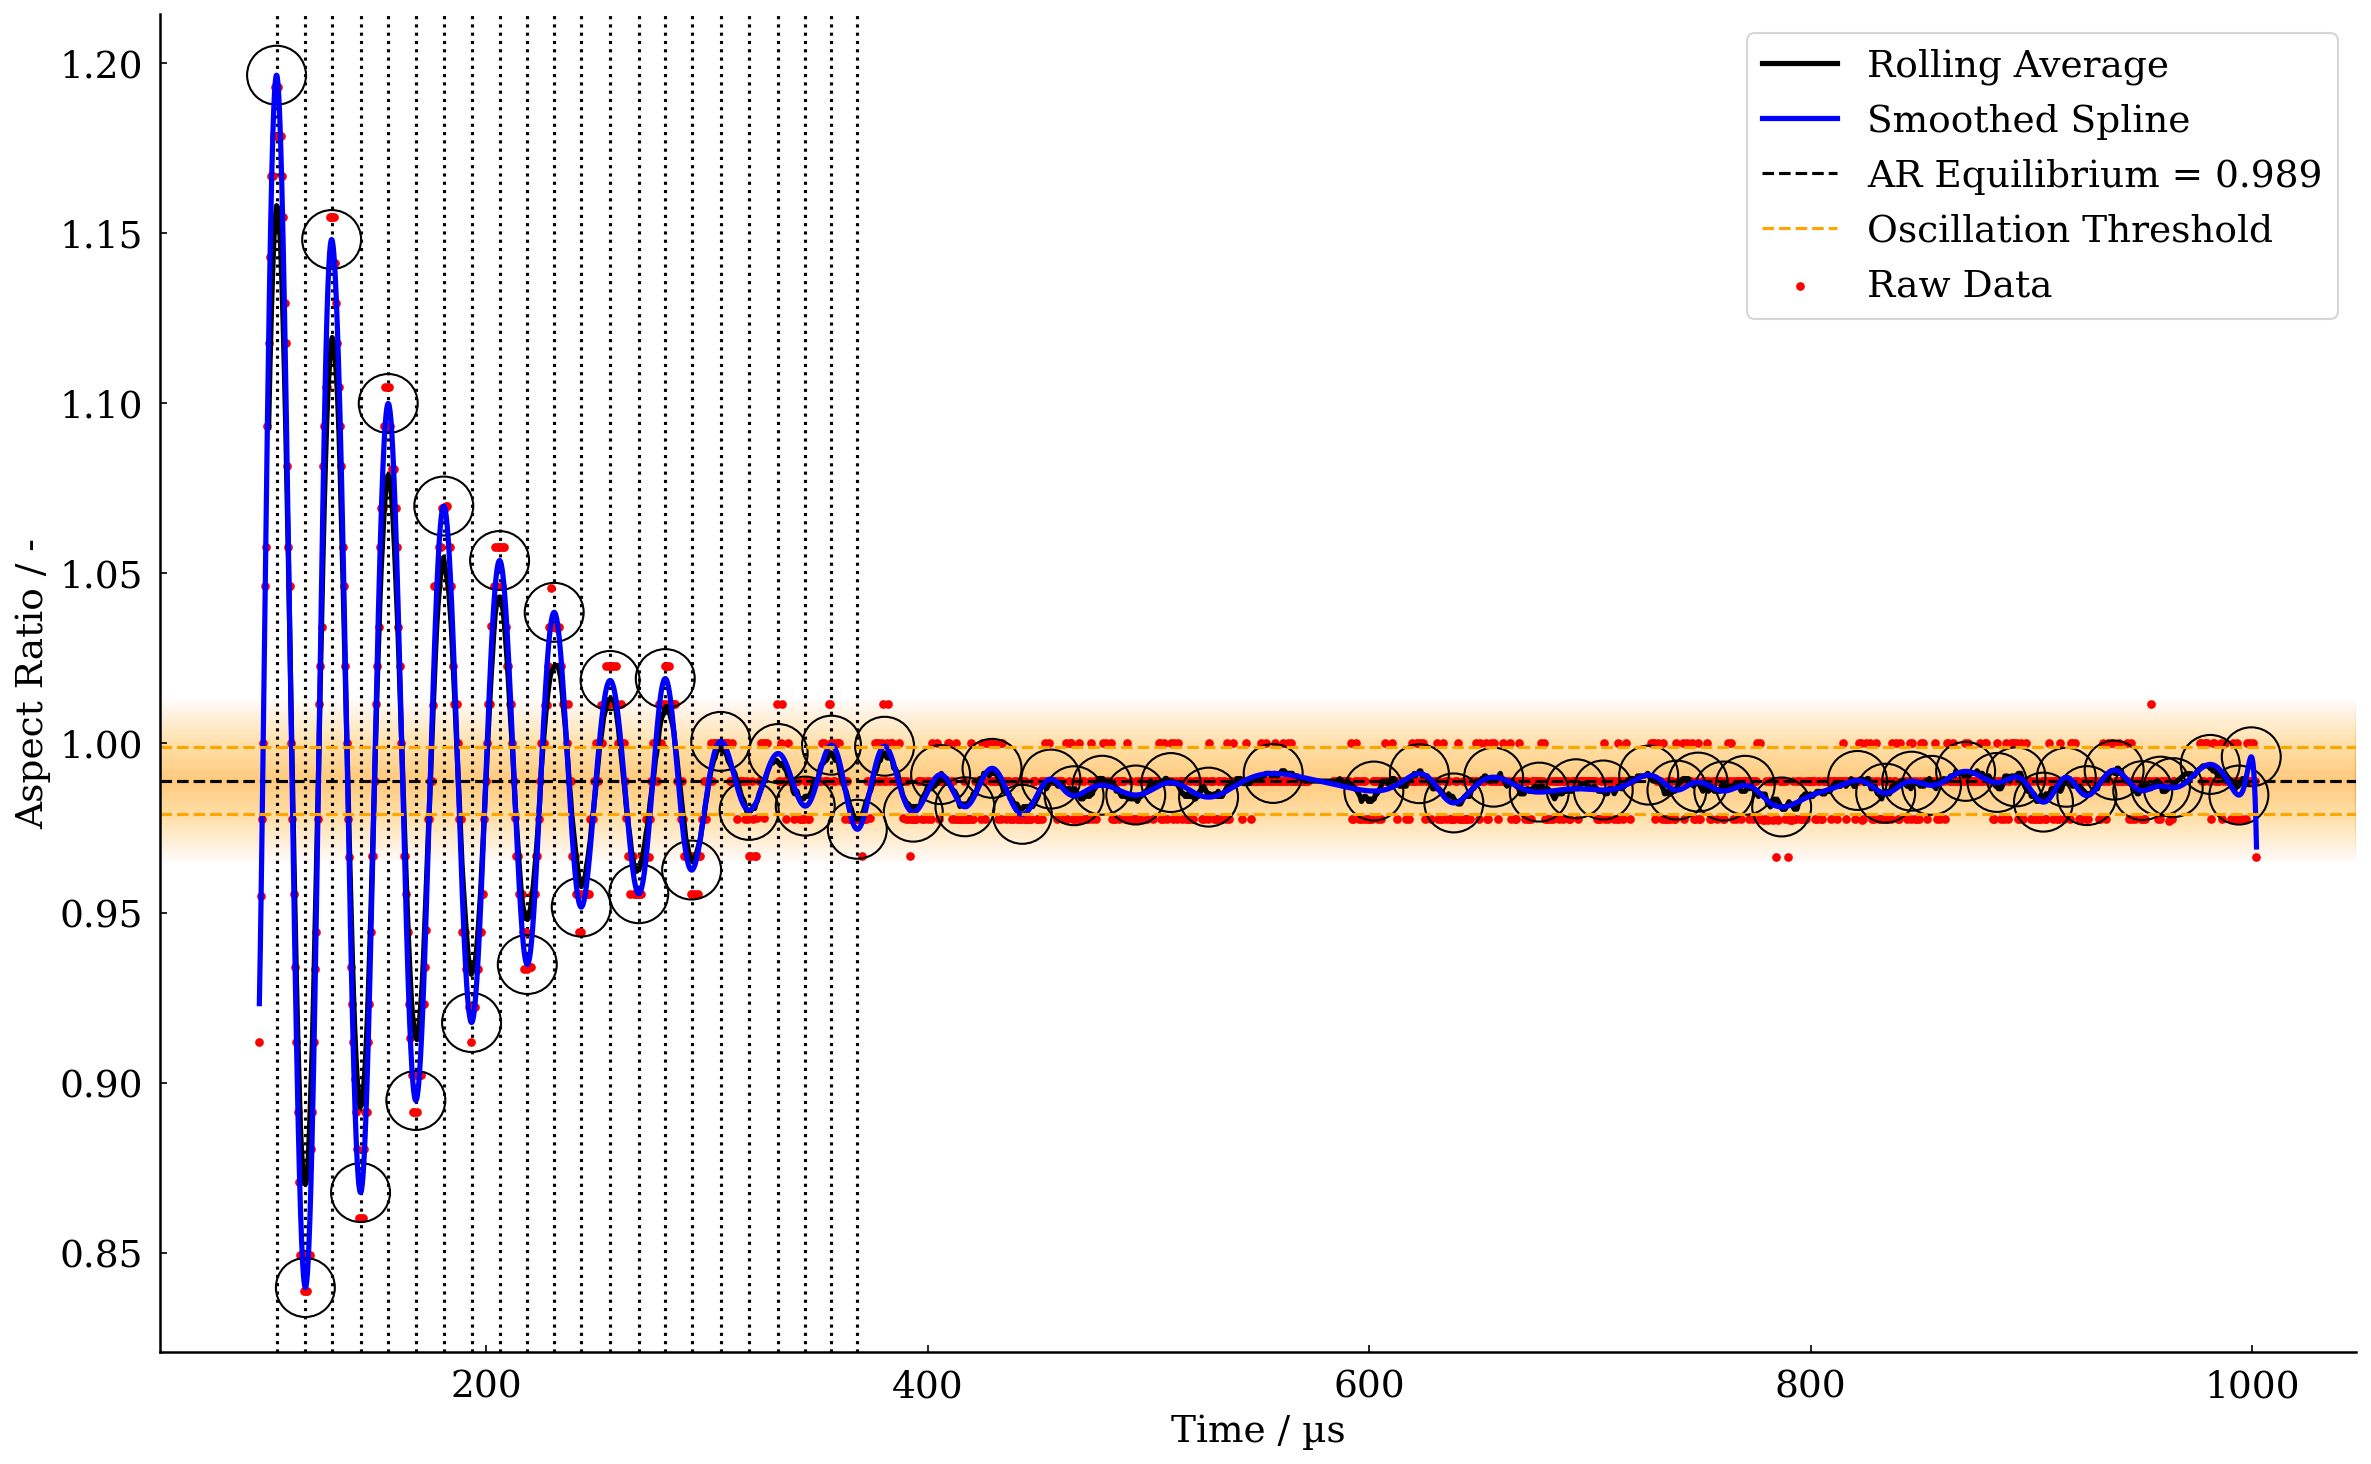

In [20]:
slice_times, sliced_data, settings_used = DOFFTA.slice_data(trimmed_data)

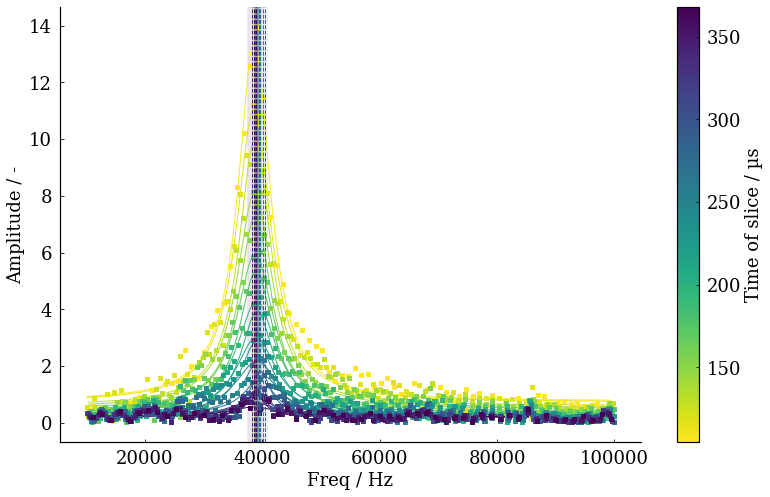

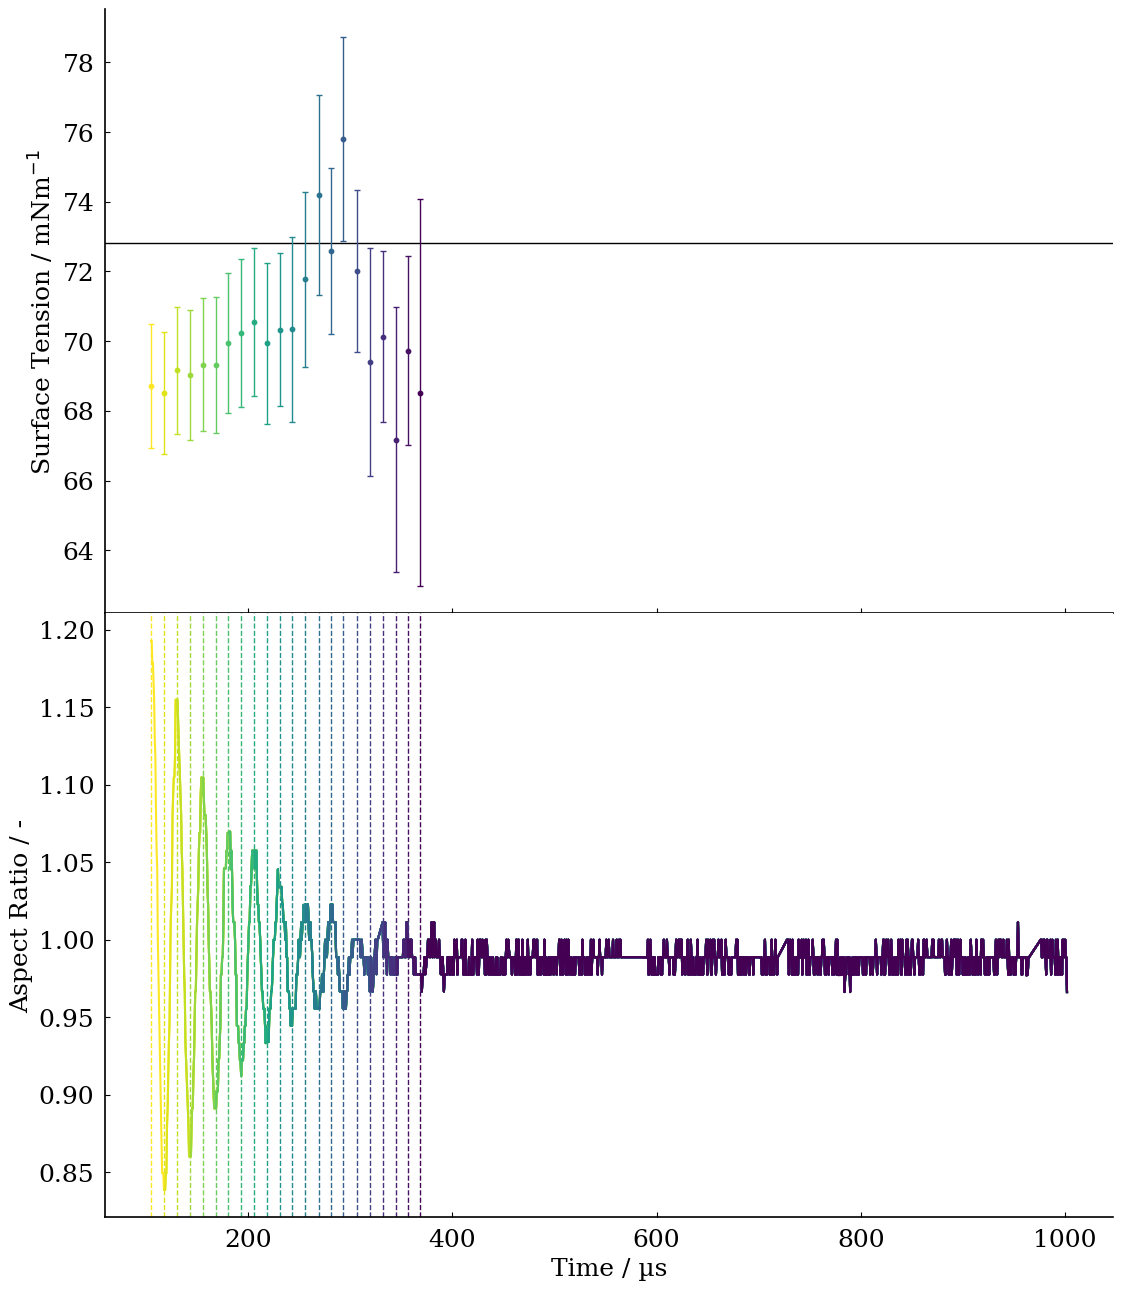

Saving: 368.1 µs freq data n data 
Done


In [21]:


sigmas, sigma_errs, lors, ffts = DOFFTA.chopped_surface_tension_calculations(sliced_data,
                                                                             slice_times,
                                                                             d_final/2,
                                                                             d_final_std/2,
                                                                             low_freq_cut_off=min_frequency,
                                                                             high_freq_cut_off=max_frequency,
                                                                             save_location=dir_path)

